# Demonstration of AI recognizing handwritten digits

In [1]:
import numpy as np

# Tensorflow + confirm GPU is visible
import tensorflow as tf
#from tensorflow.python.client import device_lib
#assert 'GPU' in str(device_lib.list_local_devices())

# Keras
import keras
from keras.models import Sequential # For Feed Forward NN
from keras.models import model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, Input # Basic layers
from keras.layers import Conv2D, MaxPooling2D # CNN layers
from keras.utils import np_utils

# confirm Keras sees the GPU
#assert len(keras.backend.tensorflow_backend._get_available_gpus()) > 0

# Plotting
from matplotlib import pyplot as plt

# Mac fixes...
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


# Import a dataset of 60'000 handwritten digits

(60000, 28, 28, 1)


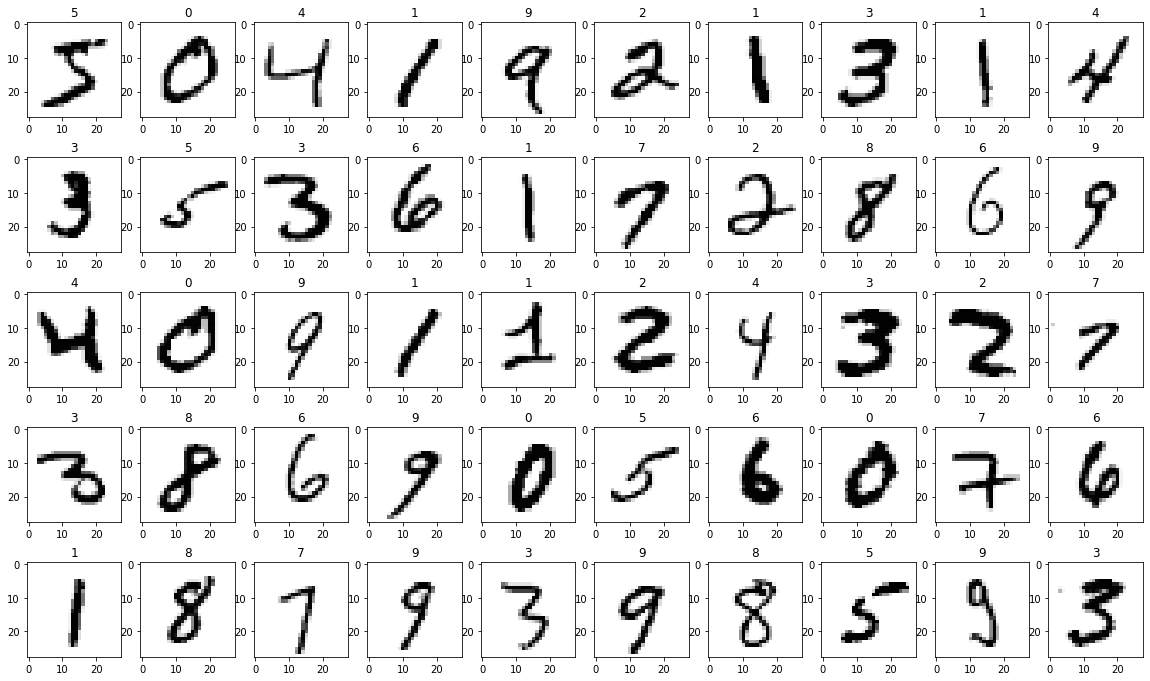

In [3]:
# Fixed random generator seed for reproducibility
np.random.seed(123)

# Load image data from MNIST
from keras.datasets import mnist

# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_viz = X_test

# Convert the input to something that works with the Tensorflow backend
# We add a field at the end indicating that there is only 1 channel (i.e. Grayscale)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# Convert from uint8 to float
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# Normalize (original is 0-255, new is 0-1)
X_train /= 255
X_test /= 255

# Reformat outcomes from labels from 1 col with numbers to 10 columns with 1|0 (categorical)
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

# Proof that we have 60k samples of 28x28 pixels, and show the first few samples
print(X_train.shape)
plt.figure(figsize=(20,12))
for i in range(50):
    a = plt.subplot(5,10,i+1)
    a.title.set_text(y_train[i])
    plt.imshow(X_train[i].reshape([28,28]), cmap='Greys')
plt.show()

# A non-AI model: Direct interpretation of inputs - coding a 'mask' by hand

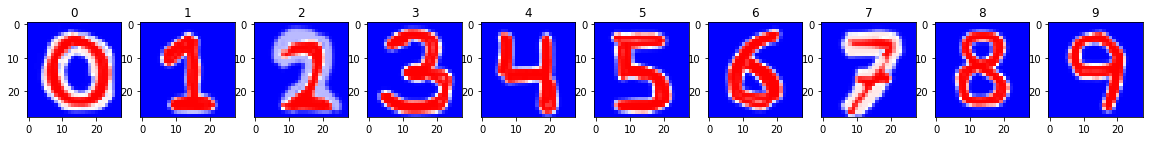

In [4]:
# Load and show masks
masks = load_masks()

plt.figure(figsize=(20,12))
for i in range(10):
    a = plt.subplot(5,10,i+1)
    a.title.set_text(i)
    plt.imshow(masks[i].reshape([28,28]), cmap='bwr') # YlOrRd
plt.show()

## How we will determine the digit - overlap with our manually defined masks:

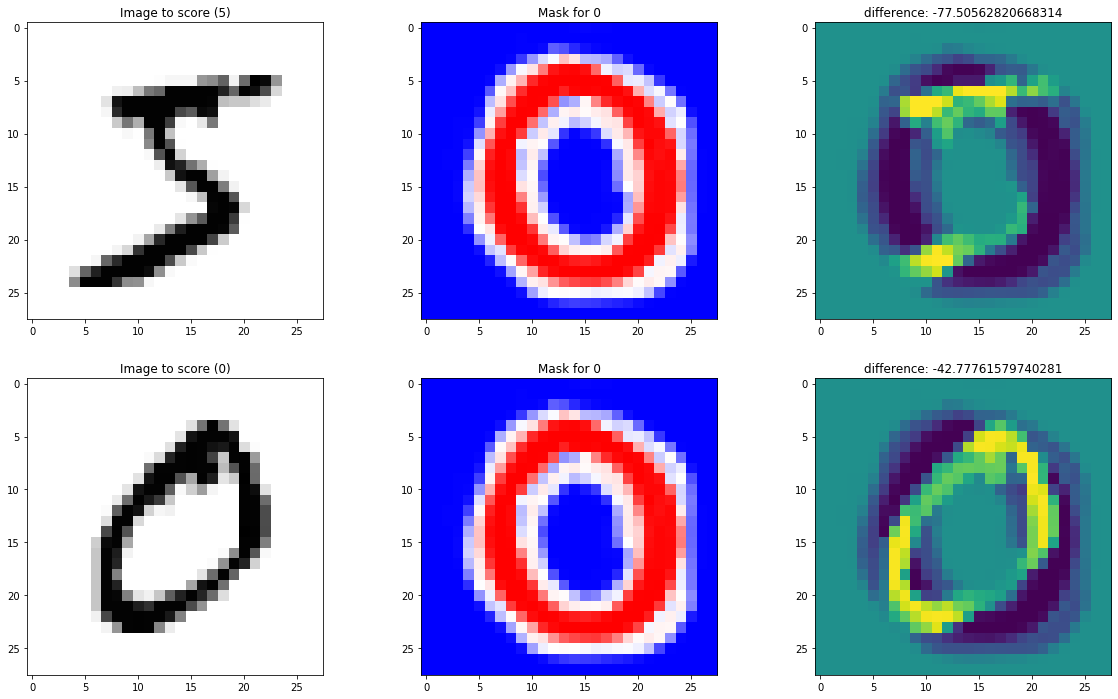

In [5]:
plt.figure(figsize=(20,12))
a = plt.subplot(2,3,1)
a.title.set_text("Image to score (5)")
a.imshow(X_train[0].reshape([28,28]), cmap='Greys')
b = plt.subplot(2,3,2)
b.title.set_text("Mask for 0")
b.imshow(masks[0].reshape([28,28]), cmap='bwr')
c = plt.subplot(2,3,3)
c.title.set_text("Difference")
diff = np.absolute(((masks[0].reshape([28,28])) * (X_train[0].reshape([28,28]) - 0.5)))
diff = (((masks[0].reshape([28,28])) * (X_train[0].reshape([28,28]) - 0.5)))
c.title.set_text("difference: " + str(np.sum(diff)))
c.imshow(diff)

i = 1
a = plt.subplot(2,3,4)
a.title.set_text("Image to score (0)")
a.imshow(X_train[i].reshape([28,28]), cmap='Greys')
b = plt.subplot(2,3,5)
b.title.set_text("Mask for 0")
b.imshow(masks[0].reshape([28,28]), cmap='bwr')
c = plt.subplot(2,3,6)
diff = np.absolute(((masks[0].reshape([28,28]) - 0.5) * (X_train[i].reshape([28,28]) - 0.5)))
diff = (((masks[0].reshape([28,28])) * (X_train[i].reshape([28,28]) - 0.5)))
c.title.set_text("difference: " + str(np.sum(diff))) 
c.imshow(diff)

plt.show()

# Performance of our manually coded digit classifier is 10% - as good as a random guess

In [6]:
correct, incorrect = 0, 0
d = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
dc = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
for i in range(len(y_test)):
    prediction = predict(masks, X_test[i].reshape([28,28]))
    actual = y_test[i]
    if prediction == actual:
        correct += 1
        d[actual] += 1
    else:
        incorrect += 1
        dc[prediction] += 1
print("Correct answers: ", correct)
print("Incorrect answers: ", incorrect)
print("Performance (% correct): ", round(correct/(correct+incorrect)*100,1))


Correct answers:  1007
Incorrect answers:  8993
Performance (% correct):  10.1


# Our first AI model: use machine learning to generate the 'Masks'

In [7]:
# Define the MASK model. 784 inputs (each pixel) feeding 10 outputs (each category) directly
mask_model = Sequential()
mask_model.add(Flatten())
mask_model.add(Dense(10, activation='softmax'))
mask_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop_monitor = keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
mask_model.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data=(X_test, Y_test), callbacks=[early_stop_monitor])

W0814 09:50:10.092885 4400651712 deprecation_wrapper.py:119] From /Users/dennis/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 09:50:10.147814 4400651712 deprecation_wrapper.py:119] From /Users/dennis/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0814 09:50:10.181370 4400651712 deprecation_wrapper.py:119] From /Users/dennis/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 09:50:10.202687 4400651712 deprecation_wrapper.py:119] From /Users/dennis/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0814 09:50:10.225513 44

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.8639 - acc: 0.7822 - val_loss: 0.4733 - val_acc: 0.8859
Epoch 2/10
60000/60000 [==============================] - 1s 11us/step - loss: 0.4297 - acc: 0.8886 - val_loss: 0.3677 - val_acc: 0.9032
Epoch 3/10
60000/60000 [==============================] - 1s 11us/step - loss: 0.3618 - acc: 0.9030 - val_loss: 0.3291 - val_acc: 0.9129
Epoch 4/10
60000/60000 [==============================] - 1s 11us/step - loss: 0.3309 - acc: 0.9102 - val_loss: 0.3076 - val_acc: 0.9147
Epoch 5/10
60000/60000 [==============================] - 1s 11us/step - loss: 0.3129 - acc: 0.9138 - val_loss: 0.2959 - val_acc: 0.9191
Epoch 6/10
60000/60000 [==============================] - 1s 11us/step - loss: 0.3009 - acc: 0.9171 - val_loss: 0.2888 - val_acc: 0.9180
Epoch 7/10
60000/60000 [==============================] - 1s 11us/step - loss: 0.2916 - acc: 0.9184 - val_loss: 0.2817 - val_acc

## Performance of the SAME approach but with machine learning is much higher: ±90%

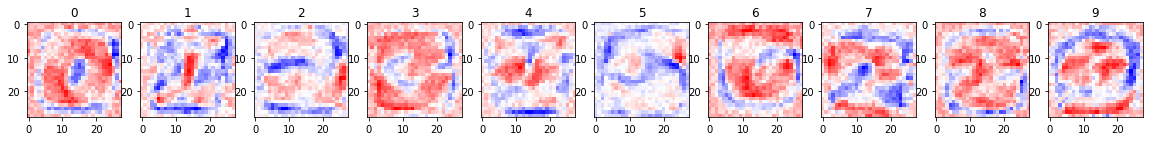

In [8]:
newmasks = layer_to_masks(mask_model.layers[1])
plt.figure(figsize=(20,12))
for i in range(newmasks.shape[0]):
    a = plt.subplot(5,10,i+1)
    a.title.set_text(i)
    a.imshow(newmasks[i], cmap='bwr')
plt.show()

# But, can we do better? Perhaps people write digits in different ways. What if we add 30 masks first and then combine them to 10 outcomes?

In [21]:
# Define the MASK2 model. 784 inputs (each pixel) feeding 30 outputs which feed 10 outputs (each category) b- 1 hidden layer
mask_model2 = Sequential()
mask_model2.add(Flatten())
mask_model2.add(Dense(30, activation='relu'))
mask_model2.add(Dense(10, activation='softmax'))
mask_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop_monitor = keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
mask_model2.fit(X_train, Y_train, epochs=25, batch_size=256, validation_data=(X_test, Y_test), callbacks=[early_stop_monitor])

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 2s 34us/step - loss: 0.6686 - acc: 0.8209 - val_loss: 0.3208 - val_acc: 0.9090
Epoch 2/25
60000/60000 [==============================] - 1s 15us/step - loss: 0.2965 - acc: 0.9169 - val_loss: 0.2601 - val_acc: 0.9253
Epoch 3/25
60000/60000 [==============================] - 1s 15us/step - loss: 0.2496 - acc: 0.9291 - val_loss: 0.2269 - val_acc: 0.9361
Epoch 4/25
60000/60000 [==============================] - 1s 16us/step - loss: 0.2197 - acc: 0.9382 - val_loss: 0.2104 - val_acc: 0.9407
Epoch 5/25
60000/60000 [==============================] - 1s 16us/step - loss: 0.1979 - acc: 0.9438 - val_loss: 0.1933 - val_acc: 0.9434
Epoch 6/25
60000/60000 [==============================] - 1s 15us/step - loss: 0.1817 - acc: 0.9482 - val_loss: 0.1852 - val_acc: 0.9460
Epoch 7/25
60000/60000 [==============================] - 1s 15us/step - loss: 0.1681 - acc: 0.9523 - val_loss: 0.1732 - val_acc

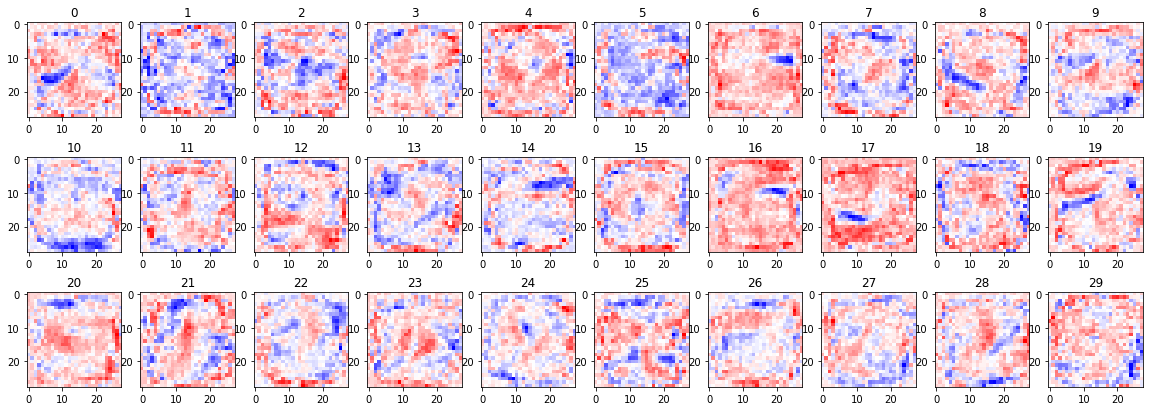

In [22]:
newmasks = layer_to_masks(mask_model2.layers[1])
plt.figure(figsize=(20,12))
for i in range(newmasks.shape[0]):
    a = plt.subplot(5,10,i+1)
    a.title.set_text(i)
    a.imshow(newmasks[i], cmap='bwr')
plt.show()

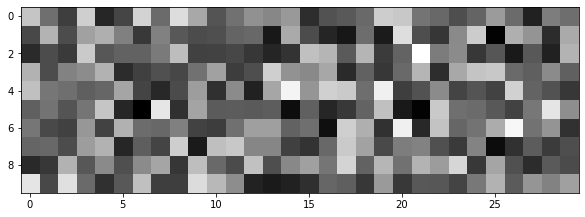

In [23]:
m3 = mask_model2.layers[2].get_weights()[0]
m3 = np.round(np.swapaxes(m3, 0, 1),2)
plt.figure(figsize=(10,10))
plt.imshow(m3, cmap='Greys')
plt.show()

In [ ]:
# Optional:Train for another 50 epochs
mask_model2.fit(X_train, Y_train, epochs=50, batch_size=256, validation_data=(X_test, Y_test), callbacks=[early_stop_monitor])
newmasks = layer_to_masks(mask_model2.layers[1])
plt.figure(figsize=(20,12))
for i in range(newmasks.shape[0]):
    a = plt.subplot(5,10,i+1)
    a.title.set_text(i)
    a.imshow(newmasks[i], cmap='bwr')
plt.show()

# Insight: We can try to match pieces of digits and then combine those to full digit recognition 

In [14]:
# Define the layers of the model
CNNmodel = Sequential()

# Convolutional part
CNNmodel.add(Conv2D(32, (5, 5), activation='relu', input_shape=(28,28,1)))
CNNmodel.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
CNNmodel.add(MaxPooling2D(pool_size=(2,2)))
CNNmodel.add(Dropout(0.25))

# Fully connected part
CNNmodel.add(Flatten())
CNNmodel.add(Dense(128, activation='relu'))
CNNmodel.add(Dropout(0.25))
CNNmodel.add(Dense(10, activation='softmax'))

# Compile
CNNmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
early_stop_monitor = keras.callbacks.EarlyStopping(patience=1, monitor='val_loss')
CNNmodel.fit(X_train, Y_train, epochs=2, batch_size=512, callbacks=[early_stop_monitor], validation_data=(X_test, Y_test))
print(round(CNNmodel.evaluate(X_test, Y_test)[1]*100,1), " procent correct")

W0814 09:55:44.268918 4400651712 deprecation_wrapper.py:119] From /Users/dennis/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0814 09:55:44.276962 4400651712 deprecation.py:506] From /Users/dennis/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 32s 528us/step - loss: 0.5922 - acc: 0.8761 - val_loss: 0.1957 - val_acc: 0.9714
Epoch 2/2
10000/10000 [==============================] - 2s 179us/step
98.2  procent correct


In [15]:
# What is the top of the line? ==> 99.5%
CNN_state_of_the_art = tf.keras.models.load_model('CNNSOTA')
print(round(CNN_state_of_the_art.evaluate(X_test, Y_test)[1]*100,1), " procent correct")

W0814 09:57:08.321120 4400651712 deprecation.py:506] From /Users/dennis/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0814 09:57:08.322011 4400651712 deprecation.py:506] From /Users/dennis/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0814 09:57:08.345847 4400651712 deprecation.py:506] From /Users/dennis/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_o

10000/10000 [==============================] - 6s 632us/sample - loss: 0.0148 - acc: 0.9946
99.5  procent correct


In [ ]:
# Training of advanced model (2 minutes per epoch)
# CNN_state_of_the_art.fit(X_train, Y_train, epochs=5, batch_size=512, validation_data=(X_test, Y_test))

In [ ]:
mask_model.summary()
print("\n\n")
CNN_state_of_the_art.summary()

## For the misclassified pictures, how difficult are they?

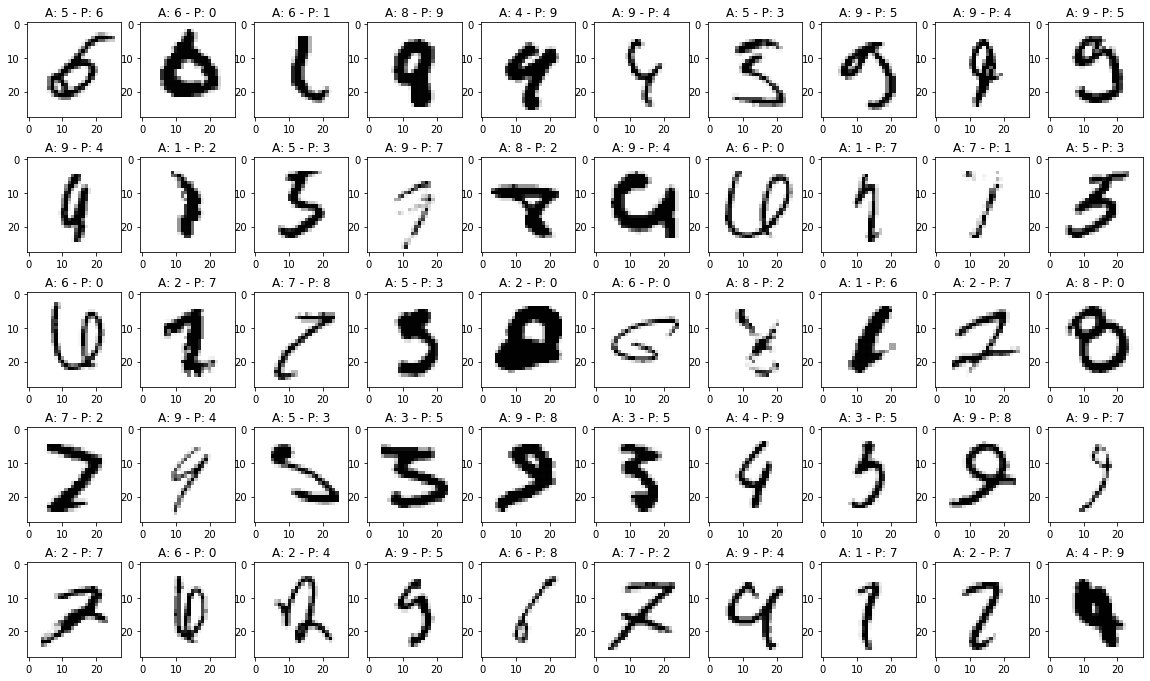

In [16]:
# Let's show a few misclassified pictures
Y_pred = CNN_state_of_the_art.predict(X_test)
delta = np.abs(Y_test - Y_pred)
indexes = np.sum(delta, axis=1).argsort()[-50:][::-1]

plt.figure(figsize=(20,12))
for i in range(50):
    a = plt.subplot(5,10,i+1)
    a.title.set_text("A: " + str(Y_test[indexes[i]].argmax(axis=0)) + " - P: " + str(Y_pred[indexes[i]].argmax(axis=0)))
    a.imshow(X_viz[indexes[i]], cmap='Greys')
plt.show()

# Note on narrow AI: each of these models will fail on any input that is not a number between 0-9

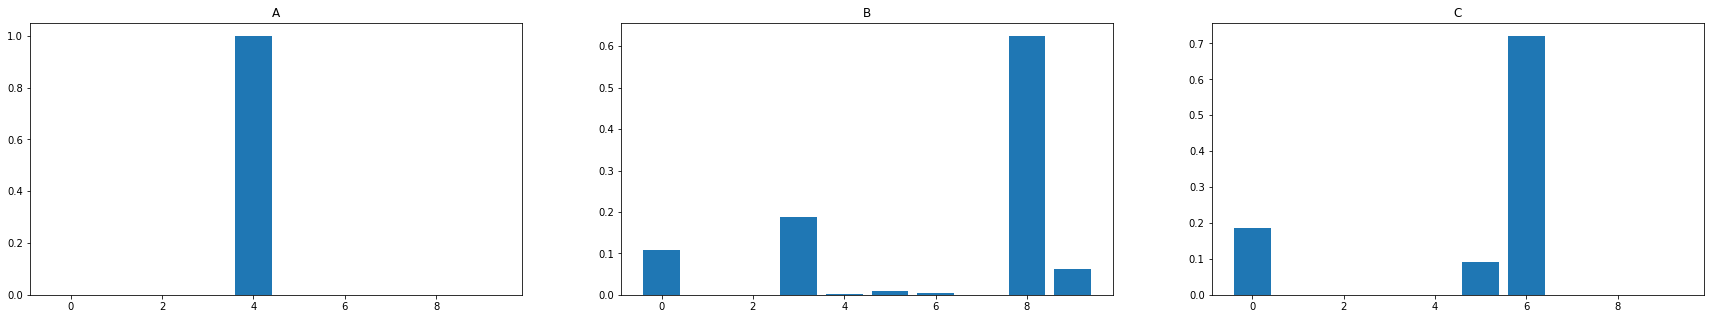

In [17]:
def import_letter(num='A'):
    from PIL import Image
    im = Image.open('%s.bmp' % num).convert(mode="L") # import image as black-and-white
    p = np.array(im) # convert to numpy array
    p = (((p - (255/2)) * -1) + (255/2)) / 255 # invert and normalize to 0-1
    p = np.array([p]).reshape([28,28,1])
    return p

la = import_letter('A')
lb = import_letter('B')
lc = import_letter('C')

result = CNN_state_of_the_art.predict(np.array([la,lb,lc]))
result

plt.figure(figsize=(30,5))
plt.xticks(np.arange(10), np.arange(10))
for i in range(3):
    a = plt.subplot(1,3,i+1)
    a.title.set_text(['A','B','C'][i])
    a.bar(np.arange(10), result[i], align='center')
plt.show()

# Visual demonstration

https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html

# Utilities

In [2]:
# import bitmap masks
def import_mask(num=0):
    from PIL import Image
    im = Image.open('%d.bmp' % num).convert(mode="L") # import image as black-and-white
    p = np.array(im) # convert to numpy array
    p = (((p - (255/2)) * -1) + (255/2)) / 255 # invert and normalize to 0-1
    p = np.array([p]).reshape([28,28,1])
    return p

def load_masks():
    masks = np.empty([10,28,28,1])
    for i in range(10):
        mask = import_mask(i)
        masks[i] = mask
    return masks

def compare_mask(mask, img):
    #diff = (((masks[0].reshape([28,28])) * (X_train[0].reshape([28,28]) - 0.5)))
    # np.sum(np.absolute((mask) * (img - 0.5))) / np.sum(mask)
    mask_coverage = np.sum(mask * img) / np.sum(mask) # e.g. 28% of mask covered
    img_coverage  = np.sum(mask * img) / np.sum(img) # e.g. 74% of image in mask
    mask_coverage = 1
    return mask_coverage * img_coverage

def predict(masks, image):
    scores = np.zeros([len(masks)])
    for i in range(len(masks)):
        scores[i] = compare_mask(masks[i], image)
    return scores.argmax(axis=0)

def layer_to_masks(layer):
    weights = layer.get_weights()[0]
    masks = np.zeros([weights.shape[1],28,28])
    for i in range((weights.shape[1])):
        masks[i] = weights[:,i].reshape([28,28])
    return masks
    
    

In [ ]:
# Kaggle winning model with 99%+ accuracy
from keras.layers import BatchNormalization

CNNmodel3 = Sequential()

CNNmodel3.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
CNNmodel3.add(BatchNormalization())
CNNmodel3.add(Conv2D(32,kernel_size=3,activation='relu'))
CNNmodel3.add(BatchNormalization())
CNNmodel3.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
CNNmodel3.add(BatchNormalization())
CNNmodel3.add(Dropout(0.4))

CNNmodel3.add(Conv2D(64,kernel_size=3,activation='relu'))
CNNmodel3.add(BatchNormalization())
CNNmodel3.add(Conv2D(64,kernel_size=3,activation='relu'))
CNNmodel3.add(BatchNormalization())
CNNmodel3.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
CNNmodel3.add(BatchNormalization())
CNNmodel3.add(Dropout(0.4))

CNNmodel3.add(Flatten())
CNNmodel3.add(Dense(128, activation='relu'))
CNNmodel3.add(BatchNormalization())
CNNmodel3.add(Dropout(0.4))
CNNmodel3.add(Dense(10, activation='softmax'))

CNNmodel3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

early_stop_monitor = keras.callbacks.EarlyStopping(patience=1, monitor='val_loss')
CNNmodel3.fit(X_train, Y_train, epochs=30, batch_size=512, callbacks=[early_stop_monitor], validation_data=(X_test, Y_test))

In [ ]:
CNN_state_of_the_art.save("CNNSOTA")